Initial Accuracy (untuned Bagging): 0.8333
Best Parameters: {'max_samples': 0.5, 'n_estimators': 100}
Tuned Accuracy: 0.8519
Cross-Validation Accuracy (mean): 0.7695


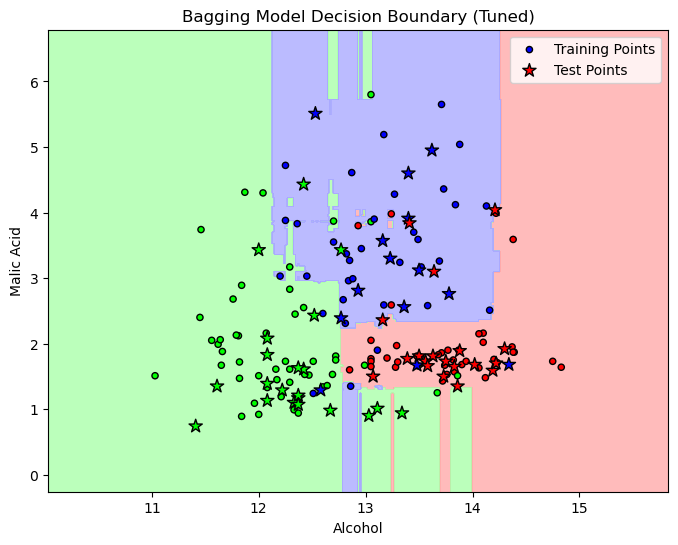

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# scikit-learn相关
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# 1. 载入 Wine 数据集，并只取前两列特征做可视化
wine = load_wine()
X = wine.data[:, :2]   # 只用 'Alcohol' 和 'Malic Acid'
y = wine.target

# 划分训练集与测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 2. 构建并训练 Bagging 分类器 (estimator=DecisionTreeClassifier)
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(),  # 注意此处是 'estimator'
    random_state=42
)
bagging_model.fit(X_train, y_train)

# 3. 初步性能评估
y_pred = bagging_model.predict(X_test)
initial_acc = accuracy_score(y_test, y_pred)
print(f"Initial Accuracy (untuned Bagging): {initial_acc:.4f}")

# 4. 使用 GridSearchCV 做超参数调优
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.75, 1.0]
}

grid_search = GridSearchCV(
    BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        random_state=42
    ),
    param_grid,
    cv=5,  # 5折交叉验证
    n_jobs=-1  # 若机器资源允许，可并行加速
)

grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# 在测试集上查看调优后模型的准确率
y_pred_best = best_model.predict(X_test)
tuned_acc = accuracy_score(y_test, y_pred_best)
print(f"Tuned Accuracy: {tuned_acc:.4f}")

# 5. 再做一次更全面的交叉验证评估（用完整 X, y）
cv_scores = cross_val_score(best_model, X, y, cv=5)
print(f"Cross-Validation Accuracy (mean): {cv_scores.mean():.4f}")

# 6. 可视化决策边界（使用调优后模型 best_model）
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, 0.01),
    np.arange(y_min, y_max, 0.01)
)

Z = best_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 设置颜色
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=cmap_light)
# 训练集
plt.scatter(
    X_train[:, 0], X_train[:, 1], 
    c=y_train, edgecolor='k', 
    s=20, cmap=cmap_bold, 
    label="Training Points"
)
# 测试集
plt.scatter(
    X_test[:, 0], X_test[:, 1], 
    c=y_test, edgecolor='k', 
    s=100, marker='*', cmap=cmap_bold, 
    label="Test Points"
)

plt.xlabel('Alcohol')
plt.ylabel('Malic Acid')
plt.title('Bagging Model Decision Boundary (Tuned)')
plt.legend()
plt.show()
